In [1347]:
from commonfunctions import *
from rle import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1348]:
from skimage.transform import resize as sk_resize
from skimage.filters import median, gaussian
from skimage.feature import canny
from skimage.filters import threshold_otsu
from collections import Counter
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rotate, hough_ellipse, hough_circle, hough_circle_peaks
from skimage import draw
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, closing, opening, square, skeletonize
from skimage.feature import match_template, blob_dog, blob_log
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches
import glob
import cv2

In [1349]:
def gray_img(img):
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray

In [1350]:
def otsu(img):
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)

In [1351]:
def get_gray(img):
    gray = rgb2gray(np.copy(img))
    return gray
def get_thresholded(img, thresh):
    return 1*(img > thresh)

In [1352]:
def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing


In [1353]:
def whitene(rle, vals, max_height):
    rlv = []
    for length, value in zip(rle, vals):
        if value == 0 and length < max_height:
            value = 1
        rlv.append((length, value))

    n_rle, n_vals = [], []
    count = 0
    for length, value in rlv:
        if value == 1:
            count = count + length
        else:
            if count > 0:
                n_rle.append(count)
                n_vals.append(1)
            
            count = 0
            n_rle.append(length)
            n_vals.append(0)
    if count > 0:
        n_rle.append(count)
        n_vals.append(1)

    return n_rle, n_vals

def remove_staff_lines(rle, vals, thickness, shape):
    n_rle, n_vals = [], []
    for i in range(len(rle)):
        rl, val = whitene(rle[i], vals[i], 2 * thickness)
        n_rle.append(rl)
        n_vals.append(val)

    return hv_decode(n_rle, n_vals, shape)

1


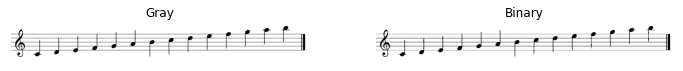

In [1354]:
img = io.imread('testcases/test-set-scanned/test-cases/04.PNG')
original = img.copy()
gray = get_gray(img)
bin_img = get_thresholded(gray, threshold_otsu(gray))
print(np.max(bin_img))
show_images([gray, bin_img], ['Gray', 'Binary'])

In [1355]:
rle, vals = hv_rle(bin_img)
most_common = get_most_common(rle)
thickness, spacing = calculate_thickness_spacing(rle, most_common)
thick_space = thickness + spacing
print(most_common, thickness, spacing)

20 2 18


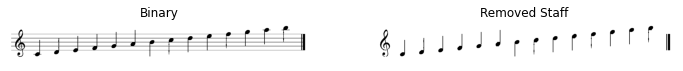

In [1356]:
no_staff_img = remove_staff_lines(rle, vals, thickness, bin_img.shape)
show_images([bin_img, no_staff_img], ['Binary', 'Removed Staff'])

In [1357]:
def histogram(img, thresh):
    hist = (np.ones(img.shape) - img).sum(dtype=np.int32, axis=1)
    _max = np.amax(hist)
    hist[hist[:] < _max * thresh] = 0
    return hist
def get_line_indices(hist):
    indices = []
    prev = 0
    for index, val in enumerate(hist):
        if val > 0 and prev <= 0:
            indices.append(index)
        prev = val
    return indices

[60, 80, 100, 120, 141]


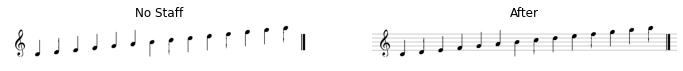

In [1358]:
line_indices = get_line_indices(histogram(bin_img, 0.8))
print(line_indices)
generated_lines_img = np.copy(no_staff_img)
lines = []
for index in line_indices:
    line = ((0, index), (bin_img.shape[1]-1, index))
    lines.append(line)
    rr, cc, val = draw.line_aa(index, 0, index, bin_img.shape[1]-1)
    generated_lines_img[rr, cc] = 0

show_images([no_staff_img, generated_lines_img], ['No Staff', 'After'])

In [1359]:
# h_lines = probabilistic_hough_line(255-gray, threshold=gray.shape[1]//2)
# lines = []
# h_lines = sorted(h_lines, key=lambda l : l[0][1])

# no_staff_lines = np.copy(no_staff_img)
# for index, line in enumerate(h_lines):
#     if index > 0 and (line[0][1] - lines[-1][0][1] < 0.9*spacing):
#         pass
#     else:
#         p1, p2 = line
#         x0, y0 = p1
#         x1, y1 = p2
#         lines.append(line)
#         rr, cc = draw.line(x0, y0, x1, y1)
#         # print(rr, cc)
#         no_staff_lines[cc, rr] = 0

# show_images([no_staff_img, no_staff_lines], ['No Staff', 'No Staff + Hough'])

In [1360]:
end_of_staff = []
for index, line in enumerate(lines):
    if index > 0 and (line[0][1] - end_of_staff[-1][1] < 4*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        end_of_staff.append((x0, y0, x1, y1))

In [1361]:
box_centers = []
spacing_between_staff_blocks = []
for i in range(len(end_of_staff)-1):
    spacing_between_staff_blocks.append(end_of_staff[i+1][1] - end_of_staff[i][1])
    if i % 2 == 0:
        offset = (end_of_staff[i+1][1] - end_of_staff[i][1])//2
        center = end_of_staff[i][1] + offset
        box_centers.append((center, offset))

max_staff_dist = np.max(spacing_between_staff_blocks)
max_margin = max_staff_dist // 2
margin = max_staff_dist // 10

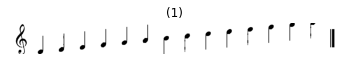

In [1362]:
end_points = []
regions_of_interest = []
regions_with_staff = []
img_with_bboxes = np.copy(gray)
for index, (center, offset) in enumerate(box_centers):
    y0 = int(center) - max_margin - offset + margin
    y1 = int(center) + max_margin + offset - margin
    end_points.append((y0, y1))

    rr, cc = draw.rectangle(start = (y0, 0), end = (y1, img_with_bboxes.shape[1]), shape=img_with_bboxes.shape)
    # io.imsave(f'blocks/region{index}.png', gray[y0:y1, 0:img_with_bboxes.shape[1]])
    regions_with_staff.append(gray[y0:y1, 0:img_with_bboxes.shape[1]])
    staff_block = no_staff_img[y0:y1, 0:img_with_bboxes.shape[1]]
    show_images([staff_block])
    regions_of_interest.append(opening(staff_block, np.ones((thickness, thickness))))
    img_with_bboxes[rr, cc] = 0

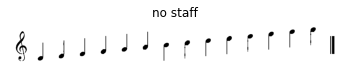

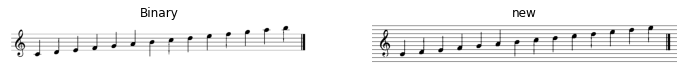

[18.5, 38.5, 58.5, 78.5, 98.5, 118.5, 138.5, 158.5, 178.5, 198.5]


In [1363]:
def get_staff_row_position(img):
    found = 0
    row_position = -1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j] == 0):
                row_position = i
                found = 1
                break
        if found == 1:
            break
    return row_position   
def get_rows(start):
    start -= most_common 
    rows = []
    row = [start]
    i = 1
    for x in range(21):
        if i < thickness:
            start += 1
            i += 1
            row.append(start)
        else:
            rows.append(row)
            row = []
            start += spacing+1
            row.append(start)
            i = 1
    return rows
def draw_staff(img,row_positions):
    image = np.copy(img)
    for x in range (len(row_positions)):
        image[row_positions[x],:] = 0
    return image
no_staff_img = remove_staff_lines(rle, vals, thickness, bin_img.shape)
show_images([no_staff_img],['no staff'])
staff_lines = otsu(bin_img - no_staff_img)
staff_lines_row_position = get_staff_row_position(staff_lines)
staff_row_positions = get_rows(staff_lines_row_position)
new_img = draw_staff(no_staff_img,staff_row_positions)
new_img = otsu(new_img)
show_images([bin_img,new_img], ['Binary','new'])   
staff_row_positions = [np.average(x) for x in staff_row_positions] 
print(staff_row_positions)

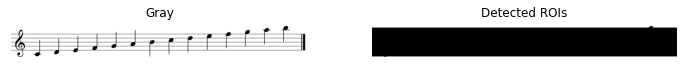

ROIs....


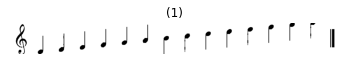

In [1364]:
show_images([gray, img_with_bboxes], ['Gray', 'Detected ROIs'])
print('ROIs....')
# if thickness % 2 == 0:
#     thickness += 1
for staff_block in regions_of_interest:
    io.imsave('staff_test.png', staff_block.astype(np.uint8))
    show_images([staff_block])
    # print(np.max(staff_block))

In [1365]:
line_indices = sorted(line_indices)
all_lines_indices = []
for i in range(5):
    line = []
    pixel = line_indices[i]
    for j in range(thickness):
        line.append(pixel)
        pixel += 1
    all_lines_indices.append(line)
print(all_lines_indices)

[[60, 61], [80, 81], [100, 101], [120, 121], [141, 142]]


In [1366]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [1367]:
def estimate_note_name(minr, maxr):
    # print(center_y)
    '''
    
    '''
    # margin = 0.25*spacing

    # print(maxr)
    # Line 
    # if np.isclose([center_y], [staff_row_positions[0][0]], )
    margin = spacing/4
    if maxr >= staff_row_positions[0]-margin and maxr <= staff_row_positions[0] + margin:
        return 'b2'
    elif maxr >= staff_row_positions[0]+margin and maxr <= staff_row_positions[0] + 3*margin:
        return 'a2'
    elif maxr >= staff_row_positions[1]-margin and maxr <= staff_row_positions[1] + margin:
        return 'g2'
    elif maxr >= staff_row_positions[1]+margin and maxr <= staff_row_positions[1] + 3*margin:
        return 'f2'
    elif maxr >= staff_row_positions[2]-margin and maxr <= staff_row_positions[2] + margin:
        return 'e2'
    elif maxr >= staff_row_positions[2]+margin and maxr <= staff_row_positions[2] + 3*margin:
        return 'd2'
    elif maxr >= staff_row_positions[3]-margin and maxr <= staff_row_positions[3] + margin:
        return 'c2'
    elif maxr >= staff_row_positions[3]+margin and maxr <= staff_row_positions[3] + 3*margin:
        return 'b'
    elif maxr >= staff_row_positions[4]-margin and maxr <= staff_row_positions[4] + margin:
        return 'a'
    elif maxr >= staff_row_positions[4]+margin and maxr <= staff_row_positions[4] + 3*margin:
        return 'g' 
    elif maxr >= staff_row_positions[5]-margin and maxr <= staff_row_positions[5] + margin:
        return 'f' 
    elif maxr >= staff_row_positions[5]+margin and maxr <= staff_row_positions[5] + 3*margin:
        return 'e'
    elif maxr >= staff_row_positions[6]-margin and maxr <= staff_row_positions[6] + margin:
        return 'd'
    elif maxr >= staff_row_positions[6]+margin and maxr <= staff_row_positions[6] + 3*margin:
        return 'c' 
    else:
        return 'N'

In [1368]:

def estim(c):
    '''
    c: maxr
    '''
    # print('New Char')
    i = 0 
    p = 0
    margin = spacing/4
    res = []
    for index,line in enumerate (staff_row_positions):
        if c >= line-margin and c <= line + margin:
            i = index
            p = 0
            res.append((i, p))
        elif c >= line+margin and c <= line + 3*margin:
            i = index
            p = 1
            res.append((i, p))
    # print(res)
    return i+1, p

In [1369]:
def estimate2(note_box):
    minr = note_box.y
    maxr = note_box.y + note_box.h

    if minr < all_lines_indices[0][0] and maxr > all_lines_indices[0][-1]:
        return 'f2'
    elif minr > all_lines_indices[0][-1] and maxr > all_lines_indices[1][0]:
        return 'e2'
    elif minr < all_lines_indices[1][0] and maxr > all_lines_indices[1][-1]:
        return 'd2'
    elif minr > all_lines_indices[1][-1] and maxr > all_lines_indices[2][0]:
        return 'c2'
    elif minr < all_lines_indices[2][0] and maxr > all_lines_indices[2][-1]:
        return 'b1'
    elif minr > all_lines_indices[2][-1] and maxr > all_lines_indices[3][0]:
        return 'a1'
    elif minr < all_lines_indices[3][0] and maxr > all_lines_indices[3][-1]:
        return 'g1'
    elif minr > all_lines_indices[3][-1] and maxr > all_lines_indices[4][0]:
        return 'f1'
    elif minr < all_lines_indices[4][-1] and maxr > all_lines_indices[4][0]:
        return 'e1'
    else:
        return 'd1'

In [1370]:
quarter_templates = ['heads/black/quarter.png', 'heads/black/solid-note.png']
quarters = [cv2.imread(temp_path, 0) for temp_path in quarter_templates]

In [1371]:
from fit import match, remove_repeated_matches
from symbol import Note
from box import Box

In [1372]:
img = np.array(255*regions_of_interest[0]).astype(np.uint8)
quarter_boxes = match(img, quarters, 50, 150, 0.7)
quarter_boxes = remove_repeated_matches([j for i in quarter_boxes for j in i], 0.5)

In [1373]:
label_map = {
    1:{
        0:'b2',
        1:'a2'
    },
    2:{
        0:'g2',
        1:'f2'
    },
    3:{
        0:'e2',
        1:'d2'
    },
    4:{
        0:'c2',
        1:'b1'
    },
    5:{
        0:'a1',
        1:'g1'
    },
    6:{
        0:'f1',
        1:'e1'
    },
    7:{
        0:'d1',
        1:'c1'
    }
}

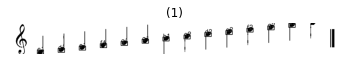

In [1374]:
quarter_img = img.copy()
# upper_dir_img = img.copy()

box = Box(0, 0, no_staff_img.shape[1], no_staff_img.shape[0])
quarter_notes = [Note(r, "4,8, 16, 32", box, [], []) for r in quarter_boxes]
# print(staff_row_positions)
# for l in all_lines_indices:
#     print(l)
# print(quarter_notes)
labels = ['c', 'd', 'e', 'f', 'g', 'a', 'b']
quarter_boxes = sorted(quarter_boxes, key=lambda b : b.x)
for idx, r in enumerate(quarter_boxes):
    r.draw(quarter_img, (0, 0, 255), 2)
    # print(r.y+r.h)
    line_idx, p = estim(r.y+r.h)
    label = label_map[line_idx][p]
    # print(estimate_note_name(r.y, r.y+r.h))
    cv2.putText(quarter_img, label, (r.x, r.y+5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    # line_idx, p = estim(r.y)
    # label = str(line_idx) + " " + str(p)
    # cv2.putText(upper_dir_img, label, (r.x, r.y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

cv2.imwrite('quarters_notes.png', quarter_img)
# cv2.imwrite('quarters_notes2.png', upper_dir_img)
show_images([quarter_img])

In [1375]:
def get_connected_components(bin_img):
    components = []
    thresh = threshold_otsu(bin_img)
    bw = closing(bin_img <= thresh, square(3))
    label_img = label(bw)
    img_label_overlay = label2rgb(label_img, image=bin_img, bg_label=0)
    for region in regionprops(label_img):
        if region.area >= 100:
            minr, minc, maxr, maxc = region.bbox
            components.append(img_with_staff[minr:maxr, minc:maxc])
    return components

In [1376]:
img = regions_of_interest[0]
img_with_staff = regions_with_staff[0]
primatives = []
prim_boxes = []
thresh = threshold_otsu(img)
bw = closing(img <= thresh, square(3))
label_img = label(bw)
img_label_overlay = label2rgb(label_img, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_label_overlay)
for region in regionprops(label_img):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        prim_boxes.append(region.bbox)
        primatives.append(img[minr:maxr, minc:maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
ax.set_axis_off()
plt.tight_layout()
plt.show()

TypeError: 'str' object is not callable

In [499]:
def union(a, b):
    minr1, minc1, maxr1, maxc1 = a
    minr2, minc2, maxr2, maxc2 = b

    minc = max(minc1, minc2)
    minr = min(minr1, minr2)
    maxc = min(maxc1, maxc2)
    maxr = max(maxr1, maxr2)
    
    return (minr, minc, maxr, maxc)

In [500]:
def intersects(a, b):
    if b[1] > a[1]:
        a, b = b, a
    
    minr1, minc1, maxr1, maxc1 = a
    minr2, minc2, maxr2, maxc2 = b

    minc = max(minc1, minc2)
    minr = min(minr1, minr2)
    maxc = min(maxc1, maxc2)
    maxr = max(maxr1, maxr2)

    if minc < maxc and minr < maxr:
        return (minr, minc, maxr, maxc)
    else:
        return None
def is_overlapped(rect, merged_rects):
    for merged_rect in merged_rects:
        if intersects(rect, merged_rect):
            return True
    return False

In [501]:
def merge_overlapped(rect, merged_rects):
    check_after = False
    new_rect = None
    for index, merged_rect in enumerate(merged_rects):
        if rect == merged_rect:
            continue
        if intersects(rect, merged_rect):
            check_after = True
            merged_rects[index] = union(rect, merged_rect)
            new_rect = merged_rect
            break
    if check_after:
        return merge_overlapped(new_rect, merged_rects)

In [502]:
def remove_overlapped_rects(rects):
    merged_rects = []
    for rect in rects:
        if is_overlapped(rect, merged_rects):
            merge_overlapped(rect, merged_rects)
        else:
            merged_rects.append(rect)
    
    # Remove duplicates
    result = []
    for rect in merged_rects:
        if not rect in result:
            result.append(rect)
    
    return result

In [503]:
# prim_boxes = remove_overlapped_rects(prim_boxes)
# primatives = []
# for box in prim_boxes:
#     minr, minc, maxr, maxc = box
#     primatives.append(img[0:img.shape[0], minc:maxc])

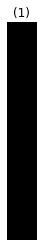

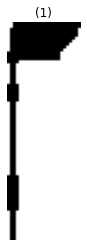

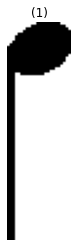

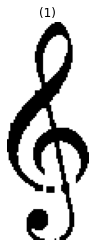

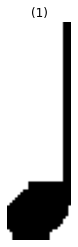

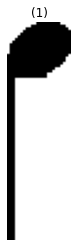

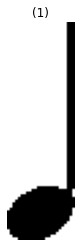

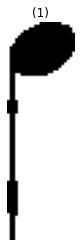

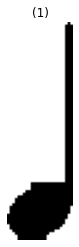

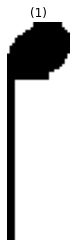

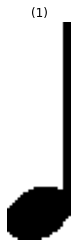

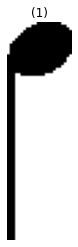

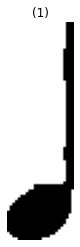

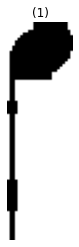

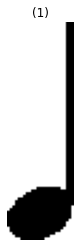

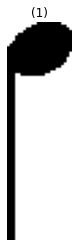

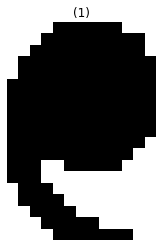

In [504]:
primatives = sorted(primatives, key=lambda p: p[0][0])
for i, prim in enumerate(primatives):
    prim = 255*prim
    # io.imsave(f'output/01/prim{i}.png', prim.astype(np.uint8))
    show_images([prim])

In [505]:
def load_knn():
    with np.load('symbols_knn_data.npz') as data:
        train = data['train']
        train_labels = data['train_labels']
    knn = cv2.ml.KNearest_create()
    knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)
    return knn, train, train_labels

In [506]:
def get_symbol(idx):
    symbol = None
    if idx == 0:
        symbol = 'DOT'
    elif idx == 1:
        symbol = 'KEY_SIGNATURE_1_#'
    elif idx == 2:
        symbol = 'QUARTER_UP'
    elif idx == 3:
        symbol = 'HALF_UP'
    elif idx == 4:
        symbol = 'TIME'
    elif idx == 5:
        symbol = 'BAR'
    elif idx == 6:
        symbol = 'QUARTER_DOWN'
    elif idx == 7:
        symbol = 'BEAM_2_EIGHTH_NOTES_UP'
    elif idx == 8:
        symbol = 'BEAM_2_EIGHTH_NOTES_DOWN'
    elif idx == 9:
        symbol = 'DOUBLE_BAR'
    elif idx == 10:
        symbol = 'REST_QUARTER'
    elif idx == 11:
        symbol = 'HALF_DOWN'
    elif idx == 12:
        symbol = 'EIGHTH_DOWN'
    elif idx == 13:
        symbol = 'KEY_SIGNATURE_2_#'
    elif idx == 14:
        symbol = 'CLEF_TREBLE'
    elif idx == 15:
        symbol = 'EIGHTH_UP'
    elif idx == 16:
        symbol = 'HALF_UP_WITH_DOT'
    elif idx == 17:
        symbol = 'TIE'
    elif idx == 18:
        symbol = 'TIME_SIGNATURE_4_4'
    elif idx == 19:
        symbol = 'QUARTER_UP_WITH_DOT'
    elif idx == 20:
        symbol = 'WHOLE'
    elif idx == 21:
        symbol = 'QUARTER_DOWN_WITH_DOT'
    elif idx == 22:
        symbol = 'KEY_SIGNATURE_1_b'
    elif idx == 23:
        symbol = 'TIME_SIGNATURE_2_4'
    else:
        symbol = 'DEFAULT'
        print('FAIL :(')
    
    return symbol

In [507]:
def get_single_pitch(boundary):
    minr, minc, maxr, maxc = boundary
    distance = abs(line_indices[2] - minr)
    index = int(round(distance*2/thick_space))%7
    res = 'G'
    if index == 0:
        res = 'C'
    elif index == 1:
        res = 'D'
    elif index == 2:
        res = 'E'
    elif index == 3:
        res = 'F'
    elif index == 4:
        res = 'G'
    elif index == 5:
        res = 'A'
    elif index == 6:
        res = 'B'
    return res

In [508]:
def reco():
    knn, train, train_labels = load_knn()
    clefs = []
    primatives.pop(0)
    primatives.pop(0)
    for index, prim in enumerate(primatives):
        prim = 255*(1-prim).astype('float32')
        prim_resized = cv2.resize(prim, dsize=(50, 50))
        prim_resized = np.array(prim_resized)
        symbol = prim_resized.reshape(-1)[:, np.newaxis].astype(np.float32).T
        ret, res, neigh, dist = knn.findNearest(symbol, k=5)
        res_idx = int(res[0][0])
        print(get_symbol(res_idx))
        print(get_single_pitch(prim_boxes[index]))
        show_images([prim_resized])
        # boundary = prim_boxes[index]
        # minr, minc, maxr, maxc = boundary
        # approx_clef_height = thick_space * 7 * 1.5
        # h = maxr - minr
        # if h >= approx_clef_height:
        #     primatives.pop(index)
        #     clefs.append(prim)
        #     show_images([prim])

QUARTER_DOWN_WITH_DOT
F


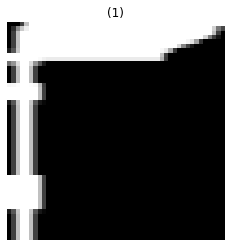

QUARTER_DOWN
F


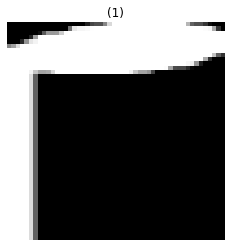

CLEF_TREBLE
E


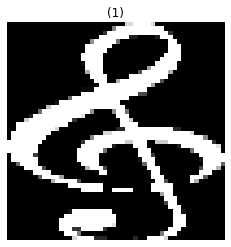

QUARTER_UP
E


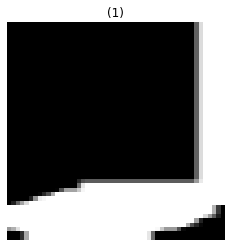

QUARTER_DOWN
E


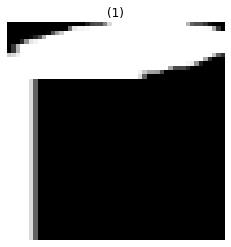

QUARTER_UP
D


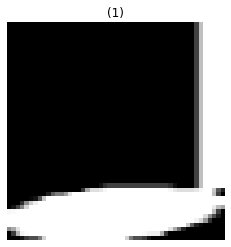

QUARTER_DOWN
D


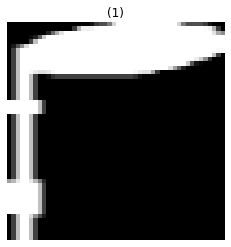

QUARTER_UP
C


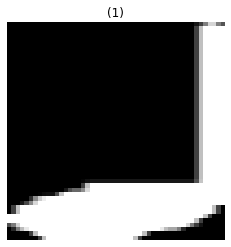

QUARTER_DOWN
C


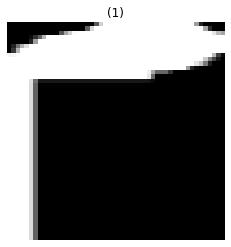

QUARTER_UP
C


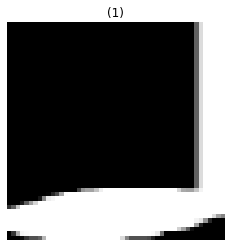

QUARTER_DOWN
C


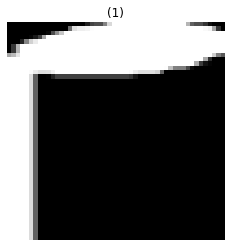

QUARTER_UP
B


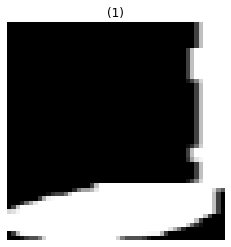

QUARTER_DOWN
B


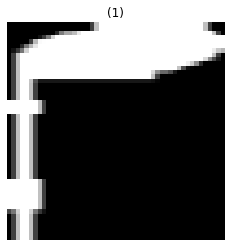

QUARTER_UP
A


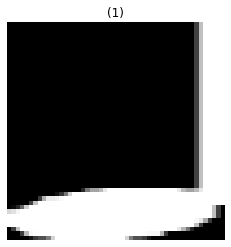

QUARTER_DOWN
A


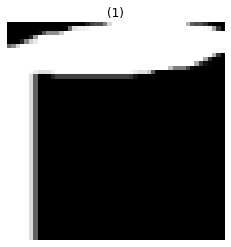

DOT
G


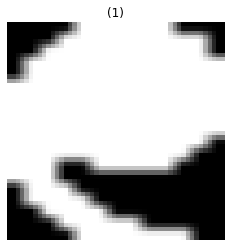

In [509]:
reco()

In [510]:
# # Blob Detection
# prim = primatives[2]
# # prim = get_gray(prim)
# print(np.max(prim))
# show_images([prim])
# # detector = cv2.SimpleBlobDetector()
# # keypoints = detector.detect(prim)

# blobs_log = blob_log(prim)
# blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
# print(blobs_log)
# dprim = np.copy(prim)
# for blob in blobs_log:
#     y, x, r = blob
#     rr, cc = draw.circle_perimeter(int(y), int(x), int(r), shape=prim.shape)
#     dprim[rr, cc] = 0
#     show_images([prim, dprim])

In [511]:
# im_with_keypoints = cv2.drawKeypoints(prim, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2.imshow("Keypoints", im_with_keypoints)
# cv2.waitKey(0)

In [512]:
# black = [io.imread(x) for x in glob.glob('heads/black/*.png')]
# # black = get_gray(black)
# # black = get_thresholded(black, threshold_otsu(black))

# half = [io.imread(x) for x in glob.glob('heads/half/*.png')]
# # half = get_gray(half)
# # half = get_thresholded(half, threshold_otsu(half))

# whole = [io.imread(x) for x in glob.glob('heads/whole/*.png')]
# # whole = get_gray(whole)
# # whole = get_thresholded(whole, threshold_otsu(whole))

In [513]:
# def detect_head(img, template, thresh):
#     if img.shape[0] < template.shape[0] or img.shape[1] < template.shape[1]:
#         img = sk_resize(img, template.shape)
#     result = match_template(img, template)
#     points = np.where(result >= thresh)
#     h, w = template.shape
#     return [[(pt[0], pt[1], w, h) for pt in zip(*points[::-1])]]

In [514]:
# def match(img, templates, start_percent, stop_percent, threshold):
#     img_width, img_height = img.shape[::-1]
#     best_location_count = -1
#     best_locations = []
#     best_scale = 1

#     x = []
#     y = []
#     for scale in [i/100.0 for i in range(start_percent, stop_percent + 1, 3)]:
#         locations = []
#         location_count = 0

#         for template in templates:
#             if (scale*template.shape[0] > img.shape[0] or scale*template.shape[1] > img.shape[1]):
#                 continue

#             template = sk_resize(template, (int(scale*template.shape[0]), int(scale*template.shape[1])))
#             template = gray_img(template)
#             result = match_template(img, template)
#             result = np.where(result >= threshold)
#             location_count += len(result[0])
#             locations += [result]

#         x.append(location_count)
#         y.append(scale)
#         if (location_count > best_location_count):
#             best_location_count = location_count
#             best_locations = locations
#             best_scale = scale
#         elif (location_count < best_location_count):
#             pass

#     return best_locations, best_scale
# def locate_templates(img, templates, start, stop, threshold):
#     locations, scale = match(img, templates, start, stop, threshold)
#     img_locations = []
#     for i in range(len(templates)):
#         # h, w = templates[i].shape
#         h = templates[i].shape[0]
#         w = templates[i].shape[1]
#         # print(templates[i].shape)
#         w *= scale
#         h *= scale
#         img_locations.append([(pt[0], pt[1], w, h) for pt in zip(*locations[i][::-1])])
#     return img_locations
# def calculate_overlap(a, b):
#     overlap_x = max(0, min(a[0]+a[2], b[0]+b[2]) - max(a[0], b[0]))
#     overlap_y = max(0, min(a[1]+a[3], b[1]+b[3]) - max(a[1], b[1]))
#     overlap_area = overlap_x*overlap_y
#     area = a[2]*a[3]
#     return overlap_area/area
# def merge2boxes(a, b):
#     x = min(a[0], b[0])
#     y = min(a[1], b[1])
#     w = max(a[0]+a[2], b[0]+b[2]) - x
#     h = max(a[1]+a[3], b[1]+b[3]) - y
#     return (x, y, w, h)
# def merge_boxes(boxes, threshold):
#     filtered_boxes = []
#     while len(boxes) > 0:
#         r = boxes.pop(0)
#         boxes.sort(key=lambda box: np.sqrt( ((box[0]+box[2]/2) - (r[0]+r[2]/2))**2 + ((box[1]+box[3]/2) - (r[1]+r[3]/2))**2))
#         merged = True
#         while merged:
#             merged = False
#             i = 0
#             for _ in range(len(boxes)):
#                 if calculate_overlap(r, boxes[i]) > threshold or calculate_overlap(boxes[i], r) > threshold:
#                     r = merge2boxes(r, boxes.pop(i))
#                     merged = True
#                 elif np.sqrt(((boxes[i][0]+boxes[i][2]/2) - (r[0]+r[2]/2))**2+((boxes[i][1]+boxes[i][3]/2) - (r[1]+r[3]/2))**2) > r[2]/2 + boxes[i][2]/2:
#                     break
#                 else:
#                     i += 1
#         filtered_boxes.append(r)
#     return filtered_boxes

In [515]:
# def estimate_the_line(line_indices, y_index, line_thickness, line_spacing):
#     lines_y = []
#     lines_y.append(max(0, line_indices[0]-line_spacing-line_thickness))
#     lines_y.extend(line_indices)
#     lines_y.append(line_indices[4]+line_spacing+line_thickness)
#     # print(lines_y)

#     labels = ['c1', 'd1', 'e1', 'f1', 'g1', 'a1', 'b1', 'c2', 'd2', 'e2', 'f2', 'g2', 'a2', 'b2']
#     res = labels[y_index%len(labels)]
    
#     if y_index >= lines_y[6]:
#         res = 'c1'
#     elif y_index > lines_y[5] and y_index < lines_y[6]:
#         res = 'd1'
#     if y_index >= lines_y[5]:
#         res = 'e1'
#     elif y_index > lines_y[4] and y_index < lines_y[5]:
#         res = 'f1'
#     if y_index >= lines_y[4]:
#         res = 'g1'
#     elif y_index > lines_y[3] and y_index < lines_y[4]:
#         res = 'a1'
#     elif y_index >= lines_y[3]:
#         res = 'b1'
#     elif y_index > lines_y[2] and y_index < lines_y[3]:
#         res = 'c2'
#     elif y_index >= lines_y[2]:
#         res = 'd2'
#     elif y_index > lines_y[1] and y_index < lines_y[2]:
#         res = 'e2'
#     elif y_index >= lines_y[1]:
#         res = 'f2'
#     elif y_index > lines_y[0] and y_index < lines_y[1]:
#         res = 'g2'
#     elif y_index >= lines_y[0]:
#         res = 'a2'
#     elif y_index < lines_y[0]:
#         res = 'b2'
    
#     return res

In [516]:
# def match_note_head(imgs, head):
#     for img in imgs:
#         heads = detect_head(img, head, 0.8)
#         print([j for i in heads for j in i])
#         bbox = merge_boxes([j for i in heads for j in i], 0.5)
#         if len(bbox) == 1:
#             print('Found :)')
#             detected = np.copy(img)
#             bbox = bbox[0]
#             rr, cc = draw.rectangle_perimeter(start = (bbox[1], bbox[0]), end = (bbox[1]+bbox[3], bbox[0]+bbox[2]), shape=img.shape)
#             rr = np.array(rr,dtype='int')
#             cc = np.array(cc,dtype='int')
#             detected[rr, cc] = 0
#             center = bbox[1]+bbox[3]//2
#             print(center)
#             print(estimate_the_line(line_indices, center, thickness, spacing))
#             print(line_indices)
#             # print(min(line_indices, key=lambda x:abs(x-center)))
#             show_images([img, detected], ['Original', 'Detected'])
#         else:
#             print('Not Found :(')

In [517]:
# def hough_detect_heads(imgs):
#     for img in imgs:
#         img = 255.0*img
#         detected = np.copy(img)

#         boxes = locate_templates(img, black, 10, 100, 0.70)
#         bbox = merge_boxes([j for i in boxes for j in i], 0.5)

        
#         if len(bbox) == 1:
#             print('Found :)')
#             bbox = bbox[0]
#             rr, cc = draw.rectangle_perimeter(start = (bbox[1], bbox[0]), end = (bbox[1]+bbox[3], bbox[0]+bbox[2]), shape=img.shape)
#             rr = np.array(rr,dtype='int')
#             cc = np.array(cc,dtype='int')
#             detected[rr, cc] = 0
#             center = bbox[1]+bbox[3]//2
#             print(center)
#             print(estimate_the_line(line_indices, center, thickness, spacing))
#             print(line_indices)
#             # print(min(line_indices, key=lambda x:abs(x-center)))
#             show_images([img, detected], ['Original', 'Detected'])
#         else:
#             print('Not Found :(')

In [518]:
# hough_detect_heads(primatives)

In [519]:
# match_note_head(primatives, black)

In [520]:
# level = ['c', 'd', 'e', 'f', 'g', 'a', 'b']
# test = np.copy(primatives[2])
# show_images([test, black, half, whole])
# template = np.copy(black)
# result = match_template(test, template)
# points = np.where(result >= 0.8)
# h, w = template.shape
# for pt in zip(*points[::-1]):
#     rr, cc = draw.rectangle_perimeter((pt[1], pt[0]), (pt[1]+h, pt[0]+w), shape=test.shape)
#     print(pt[1]+h//2)
#     print(level[(pt[1]+h//2)%7])
#     test[rr, cc] = 0
# show_images([test, black, half, whole])

In [521]:
# lower, upper, samples, clef_thresh = 0.2, 1.0, 20, 0.7

# clef_imgs = {
#     "treble": [io.imread('dataset/treble_1.jpg'), io.imread('dataset/treble_2.jpg')],
#     "bass": [io.imread('dataset/bass_1.jpg')],
#     "clef": [io.imread('clef8.jpg')]
# }

In [522]:
# '''
# An imutil function: https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py#L65
# '''
# def resize(image, width=None, height=None):
#     # initialize the dimensions of the image to be resized and
#     # grab the image size
#     dim = None
#     (h, w) = image.shape[:2]

#     # if both the width and height are None, then return the
#     # original image
#     if width is None and height is None:
#         return image

#     # check to see if the width is None
#     if width is None:
#         # calculate the ratio of the height and construct the
#         # dimensions
#         r = height / float(h)
#         dim = (int(w * r), height)

#     # otherwise, the height is None
#     else:
#         # calculate the ratio of the width and construct the
#         # dimensions
#         r = width / float(w)
#         dim = (width, int(h * r))

#     # resize the image
#     resized = sk_resize(image, dim)

#     # return the resized image
#     return resized

In [523]:
# def match(imgs, templates, start, stop, samples, thresh):
#     for img in imgs:
#         # template = canny(template, low_threshold=50, high_threshold=200)
#         for template in templates:
#             template = gray_img(template)
#             h, w = template.shape[:2]
#             gimg = gray_img(img)
#             found = None
#             for scale in np.linspace(start, stop, samples)[::-1]:
#                 resized = resize(template, width=int(template.shape[1]*scale))
#                 r = template.shape[1] / float(resized.shape[1])

#                 if np.any(np.less(gimg.shape, template.shape)):
#                     break

#                 # edged = canny(resized, low_threshold=50, high_threshold=100)
#                 result = match_template(gimg, resized)
#                 # result = np.where(result >= thresh)
#                 max_loc = np.unravel_index(np.argmax(np.copy(result)), result.shape)[::-1]
#                 # print(max_loc)
#                 max_val = result[max_loc[1], max_loc[0]]
#                 # print(max_val)
#                 if found is None or max_val > found[0]:
#                     found = (max_val, max_loc, r)
            
#             if found is not None:
#                 (_, max_loc, r) = found
#                 (minc, minr) = (int(max_loc[0]*r), int(max_loc[1]*r))
#                 (maxc, maxr) = (int((max_loc[0]+w)*r), int((max_loc[1]+h)*r))
#                 # print(minr, minc)
#                 # print(maxr, maxc)
#                 rr, cc = draw.rectangle(start=(minr, minc), end=(maxr, maxc), shape=img.shape)
#                 img[rr, cc] = 0
#                 # print(rr)
#                 # print(cc)
#                 show_images([template], ['Current Template'])
#                 show_images([img], ['Detected Image'])

In [524]:
# def match2(img,template,threshold):
#     template = gray_img(template)
#     result = match_template(img,template)
#     print(result)
#     return result > threshold

# prim = primatives[0]
# show_images([prim, skelon])
# for clef in clef_imgs:
#     for clef_img in clef_imgs[clef]:
#         clef_img = gray_img(clef_img)
#         if prim.shape != clef_img.shape:
#             prim = sk_resize(prim, clef_img.shape)
#         print('Trying....')
#         skelon = skeletonize(1-otsu(prim))
#         clef_img = skeletonize(1-otsu(clef_img))
#         show_images([skelon, clef_img])
#         found = match2(skelon,clef_img,0.5)
#         print('Finished Detection...\n')
#         if found:
#             print("Found 🙂")
#             show_images([clef_img], ['Detected Clef'])
#         else:
#             print("Not Found 🙁")

In [525]:

# for clef in clef_imgs:
#     match2(regions_with_staff, clef_imgs[clef], 0.2, 1.8, 50, 0.1)